In [2]:
!nvidia-smi

Fri Apr  5 05:50:51 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.72       Driver Version: 410.72       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    31W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   65C    P0    31W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [3]:
!export CUDA_DEVICE_ORDER="PCI_BUS_ID"
!export CUDA_VISIBLE_DEVICES="0,1,2,3"

In [4]:
# import resources
import numpy as np
import torch
torch.cuda.empty_cache()
import helper
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

# random seed (for reproducibility)
seed = 1
# set random seed for numpy
np.random.seed(seed)
# set random seed for pytorch
torch.manual_seed(seed)

In [5]:
from torchvision import datasets

class RetinaTrain(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(RetinaTrain, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        _, path = path.split("train")
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [6]:
class RetinaTest(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(RetinaTest, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        _, path = path.split("train")
        path = path[4:]
        path = path[:-5]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [7]:
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 6
# how many samples per batch to load
batch_size = 6
print(batch_size)
# convert data to Tensors
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor()])

# choose the training and test datasets

train_dir = "../data/train/"
train_data = RetinaTrain(train_dir, transform=transform)

# test_dir = "../dr-dataset/test/"
# test_data = RetinaTest(test_dir, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

# test_loader = torch.utils.data.DataLoader(test_data, 
#                                           batch_size=batch_size, 
#                                           num_workers=num_workers, shuffle=False)

12


torch.Size([1, 290, 290])
tensor(1)
/1/32200_right.tiff


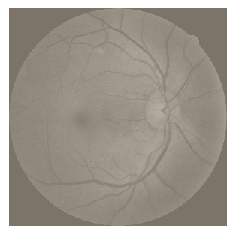

In [8]:
images, labels, paths = next(iter(train_loader))
helper.imshow(images[0], normalize=True)
print(images[0].shape)
print(labels[0])
print(paths[0])

## First Layer: Convolutional Layer

In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
class ConvLayer(nn.Module):
    
    def __init__(self, in_channels=1, out_channels=256):
        '''Constructs the ConvLayer with a specified input and output size.
           param in_channels: input depth of an image, default value = 1
           param out_channels: output depth of the convolutional layer, default value = 256
           '''
        super(ConvLayer, self).__init__()

        # defining a convolutional layer of the specified size
        self.conv = nn.Conv2d(in_channels, out_channels, 
                              kernel_size=9, stride=1, padding=0)

    def forward(self, x):
        '''Defines the feedforward behavior.
           param x: the input to the layer; an input image
           return: a relu-activated, convolutional layer
           '''
        # applying a ReLu activation to the outputs of the conv layer
        features = F.relu(self.conv(x)) # will have dimensions (batch_size, 256, 282, 282)
#         print("features.shape", features.shape)
        return features
    

## Second Layer: Primary Capsules

In [11]:
class PrimaryCaps(nn.Module):
    
    def __init__(self, num_capsules=4, in_channels=256, out_channels=32):
        '''Constructs a list of convolutional layers to be used in 
           creating capsule output vectors.
           param num_capsules: number of capsules to create
           param in_channels: input depth of features, default value = 256
           param out_channels: output depth of the convolutional layers, default value = 32
           '''
        super(PrimaryCaps, self).__init__()

        # creating a list of convolutional layers for each capsule I want to create
        # all capsules have a conv layer with the same parameters
        self.capsules = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                      kernel_size=9, stride=2, padding=0)
            for _ in range(num_capsules)])
        print("self.capsules", self.capsules)
    
    def forward(self, x):
        '''Defines the feedforward behavior.
           param x: the input; features from a convolutional layer
           return: a set of normalized, capsule output vectors
           '''
        # get batch size of inputs
        batch_size = x.size(0)
        # reshape convolutional layer outputs to be (batch_size, vector_dim=1152, 1)
        u = [capsule(x).view(batch_size, 32 * 137 * 137, 1) for capsule in self.capsules]
#         print("u", u)
        # stack up output vectors, u, one for each capsule
        u = torch.cat(u, dim=-1)
        # squashing the stack of vectors
        u_squash = self.squash(u)
        return u_squash
    
    def squash(self, input_tensor):
        '''Squashes an input Tensor so it has a magnitude between 0-1.
           param input_tensor: a stack of capsule inputs, s_j
           return: a stack of normalized, capsule output vectors, v_j
           '''
        squared_norm = (input_tensor ** 2).sum(dim=-1, keepdim=True)
        scale = squared_norm / (1 + squared_norm) # normalization coeff
        output_tensor = scale * input_tensor / torch.sqrt(squared_norm)    
        return output_tensor
    

## Third Layer: Digit Capsules

In [12]:
import helpers # to get transpose softmax function

# dynamic routing
def dynamic_routing(b_ij, u_hat, squash, routing_iterations=3):
    '''Performs dynamic routing between two capsule layers.
       param b_ij: initial log probabilities that capsule i should be coupled to capsule j
       param u_hat: input, weighted capsule vectors, W u
       param squash: given, normalizing squash function
       param routing_iterations: number of times to update coupling coefficients
       return: v_j, output capsule vectors
       '''    
    # update b_ij, c_ij for number of routing iterations
    for iteration in range(routing_iterations):
        # softmax calculation of coupling coefficients, c_ij
        c_ij = helpers.softmax(b_ij, dim=2)

        # calculating total capsule inputs, s_j = sum(c_ij*u_hat)
        s_j = (c_ij * u_hat).sum(dim=2, keepdim=True)

        # squashing to get a normalized vector output, v_j
        v_j = squash(s_j)

        # if not on the last iteration, calculate agreement and new b_ij
        if iteration < routing_iterations - 1:
            # agreement
            a_ij = (u_hat * v_j).sum(dim=-1, keepdim=True)
            
            # new b_ij
            b_ij = b_ij + a_ij
    
    return v_j # return latest v_j
    

In [13]:
# it will also be relevant, in this model, to see if I can train on gpu
TRAIN_ON_GPU = torch.cuda.is_available()

if(TRAIN_ON_GPU):
    print('Training on GPU!')
else:
    print('Only CPU available')

Training on GPU!


In [14]:
class DigitCaps(nn.Module):
    
    def __init__(self, num_capsules=5, previous_layer_nodes=32*137*137, 
                 in_channels=4, out_channels=8):
        '''Constructs an initial weight matrix, W, and sets class variables.
           param num_capsules: number of capsules to create
           param previous_layer_nodes: dimension of input capsule vector, default value = 32*137*137
           param in_channels: number of capsules in previous layer, default value = 4
           param out_channels: dimensions of output capsule vector, default value = 8
           '''
        super(DigitCaps, self).__init__()

        # setting class variables
        self.num_capsules = num_capsules
        self.previous_layer_nodes = previous_layer_nodes # vector input (dim=1152)
        self.in_channels = in_channels # previous layer's number of capsules

        # starting out with a randomly initialized weight matrix, W
        # these will be the weights connecting the PrimaryCaps and DigitCaps layers
        self.W = nn.Parameter(torch.randn(num_capsules, previous_layer_nodes, 
                                          in_channels, out_channels))

    def forward(self, u):
        '''Defines the feedforward behavior.
           param u: the input; vectors from the previous PrimaryCaps layer
           return: a set of normalized, capsule output vectors
           '''
        
        # adding batch_size dims and stacking all u vectors
        u = u[None, :, :, None, :]
        # 4D weight matrix
        W = self.W[:, None, :, :, :]
        
        # calculating u_hat = W*u
        u_hat = torch.matmul(u, W)

        # getting the correct size of b_ij
        # setting them all to 0, initially
        b_ij = torch.zeros(*u_hat.size())
        
        # moving b_ij to GPU, if available
        if TRAIN_ON_GPU:
            b_ij = b_ij.cuda()

        # update coupling coefficients and calculate v_j
        v_j = dynamic_routing(b_ij, u_hat, self.squash, routing_iterations=3)

        return v_j # return final vector outputs
    
    
    def squash(self, input_tensor):
        '''Squashes an input Tensor so it has a magnitude between 0-1.
           param input_tensor: a stack of capsule inputs, s_j
           return: a stack of normalized, capsule output vectors, v_j
           '''
        # same squash function as before
        squared_norm = (input_tensor ** 2).sum(dim=-1, keepdim=True)
        scale = squared_norm / (1 + squared_norm) # normalization coeff
        output_tensor = scale * input_tensor / torch.sqrt(squared_norm)    
        return output_tensor
    

# Decoder 

## Linear Layers

In [15]:
class Decoder(nn.Module):
    
    def __init__(self, input_vector_length=8, input_capsules=5, hidden_dim=512):
        '''Constructs an series of linear layers + activations.
           param input_vector_length: dimension of input capsule vector, default value = 16
           param input_capsules: number of capsules in previous layer, default value = 10
           param hidden_dim: dimensions of hidden layers, default value = 512
           '''
        super(Decoder, self).__init__()
        
        # calculate input_dim
        input_dim = input_vector_length * input_capsules
        
        # define linear layers + activations
#         self.linear_layers = nn.Sequential(
#             nn.Linear(input_dim, 295*150), # first hidden layer
#             nn.ReLU(inplace=True),
#             nn.Linear(295*150, 295*295), # second, twice as deep
#             nn.ReLU(inplace=True),
#             nn.Linear(295*295, 290*290), # can be reshaped into 28*28 image
#             nn.Sigmoid() # sigmoid activation to get output pixel values in a range from 0-1
#             )
        
    def forward(self, x):
        '''Defines the feedforward behavior.
           param x: the input; vectors from the previous DigitCaps layer
           return: two things, reconstructed images and the class scores, y
           '''
        classes = (x ** 2).sum(dim=-1) ** 0.5
        classes = F.softmax(classes, dim=-1)

        # find the capsule with the maximum vector length
        # here, vector length indicates the probability of a class' existence
        _, max_length_indices = classes.max(dim=1)
        
        # create a sparse class matrix
        sparse_matrix = torch.eye(5) # 10 is the number of classes
        if TRAIN_ON_GPU:
            sparse_matrix = sparse_matrix.cuda()
        # get the class scores from the "correct" capsule
        y = sparse_matrix.index_select(dim=0, index=max_length_indices.data)
        
        # create reconstructed pixels
#         x = x * y[:, :, None]
        # flatten image into a vector shape (batch_size, vector_dim)
#         flattened_x = x.view(x.size(0), -1)
        # create reconstructed image vectors
#         reconstructions = self.linear_layers(flattened_x)
        
        # return reconstructions and the class scores, y
        return y

## Put it All Together 

Finally, I'll use *all* the layers I defined above to create a complete Capsule Network! Recall that the order of these layers is as follows:
1. ConvLayer
2. PrimaryCaps
3. DigitCaps
4. Decoder

In [16]:
class CapsuleNetwork(nn.Module):
    
    def __init__(self):
        '''Constructs a complete Capsule Network.'''
        super(CapsuleNetwork, self).__init__()
        self.conv_layer = ConvLayer()
        self.primary_capsules = PrimaryCaps()
        self.digit_capsules = DigitCaps()
        self.decoder = Decoder()
                
    def forward(self, images):
        '''Defines the feedforward behavior.
           param images: the original MNIST image input data
           return: output of DigitCaps layer, reconstructed images, class scores
           '''
        primary_caps_output = self.primary_capsules(self.conv_layer(images))
        caps_output = self.digit_capsules(primary_caps_output).squeeze().transpose(0,1)
        y = self.decoder(caps_output)
        return caps_output, y
    

In [17]:
# instantiate and print net
# device = torch.device("cuda:0")
# print(device)
print("Let's use %d GPUs" % torch.cuda.device_count())
capsule_net = CapsuleNetwork()
capsule_net = nn.DataParallel(capsule_net)
print(capsule_net)
# move model to GPU, if available 
if TRAIN_ON_GPU:
    capsule_net.cuda()

Let's use 2 GPUs
self.capsules ModuleList(
  (0): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
  (1): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
  (2): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
  (3): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
)
DataParallel(
  (module): CapsuleNetwork(
    (conv_layer): ConvLayer(
      (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
    )
    (primary_capsules): PrimaryCaps(
      (capsules): ModuleList(
        (0): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
        (1): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
        (2): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
        (3): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      )
    )
    (digit_capsules): DigitCaps()
    (decoder): Decoder()
  )
)


## Custom Loss

In [18]:
class CapsuleLoss(nn.Module):
    
    def __init__(self):
        '''Constructs a CapsuleLoss module.'''
        super(CapsuleLoss, self).__init__()
#         self.reconstruction_loss = nn.MSELoss(size_average=False)

    def forward(self, x, labels, images):
        '''Defines how the loss compares inputs.
           param x: digit capsule outputs
           param labels: 
           param images: the original MNIST image input data
           param reconstructions: reconstructed MNIST image data
           return: weighted margin and reconstruction loss, averaged over a batch
           '''
        batch_size = x.size(0)
        
        ##  calculate the margin loss   ##
        
        # get magnitude of digit capsule vectors, v_c
        v_c = torch.sqrt((x**2).sum(dim=2, keepdim=True))

        # calculate "correct" and incorrect loss
        left = F.relu(0.9 - v_c).view(batch_size, -1)
        right = F.relu(v_c - 0.1).view(batch_size, -1)
        
        # sum the losses, with a lambda = 0.5

        margin_loss = labels * left + 0.5 * (1. - labels) * right
        margin_loss = margin_loss.sum()

        ##  calculate the reconstruction loss   ##
#         images = images.view(reconstructions.size()[0], -1)
#         reconstruction_loss = self.reconstruction_loss(reconstructions, images)

        # return a weighted, summed loss, averaged over a batch size
#         return (margin_loss + 0.0005 * reconstruction_loss) / images.size(0)
        return (margin_loss) / images.size(0)





### Specify Loss Function and [Optimizer](http://pytorch.org/docs/stable/optim.html)

In [19]:
import torch.optim as optim

# custom loss
criterion = CapsuleLoss()

# Adam optimizer with default params
optimizer = optim.Adam(capsule_net.parameters())

# Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

In [20]:
def train(capsule_net, criterion, optimizer, 
          n_epochs, print_every):
    '''Trains a capsule network and prints out training batch loss statistics.
       Saves model parameters if *validation* loss has decreased.
       param capsule_net: trained capsule network
       param criterion: capsule loss function
       param optimizer: optimizer for updating network weights
       param n_epochs: number of epochs to train for
       param print_every: batches to print and save training loss, default = 100
       return: list of recorded training losses
       '''

    # track training loss over time
    losses, test_losses = [], []
    # one epoch = one pass over all training data 
    for epoch in range(1, n_epochs+1):
        print("inside loop")
        # initialize training loss
        epoch_start = datetime.datetime.now().replace(microsecond=0)
        train_loss = 0.0
        
        capsule_net.train() # set to train mode
    
        # get batches of training image data and targets
        for batch_i, (images, target, path) in enumerate(train_loader):
            # reshape and get target class
#             print(path)
            target = torch.eye(5).index_select(dim=0, index=target)

            if TRAIN_ON_GPU:
                images, target = images.cuda(), target.cuda()

            # zero out gradients
            optimizer.zero_grad()
            # get model outputs
            caps_output, y = capsule_net(images)
            # calculate loss
            loss = criterion(caps_output, target, images)
            # perform backpropagation and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item() # accumulated training loss
            
            # print and record training stats
            if batch_i != 0 and batch_i % print_every == 0:
                avg_train_loss = train_loss/print_every
                losses.append(avg_train_loss)
                print('Epoch: {} \tTraining Loss: {:.8f}'.format(epoch, avg_train_loss))
                train_loss = 0 # reset accumulated training loss
        
#         else:
#             test_loss = 0.0
#             accuracy = 0
            
#             with torch.no_grad():
#                 for images, target, paths in test_loader:
                    
#                     target = torch.eye(5).index_select(dim=0, index=target)
                    
#                     if TRAIN_ON_GPU:
#                         images, target = images.cuda(), target.cuda()
                    
#                     caps_output, y = capsule_net(images)
                    
#                     loss = criterion(caps_output, target, images)
                    
#                     test_loss += loss.item()
#             test_losses.append(test_loss/len(test_loader))
#             print('Epoch: {} \tValidation Loss: {:.8f}'.format(epoch, test_loss/len(test_loader)))
        
        epoch_end = datetime.datetime.now().replace(microsecond=0)
        print(epoch_end-epoch_start)
        save_as = 'saved_model/pytorch_newer_' + str(epoch) +'.pt'
        torch.save({
            'epoch': epoch,
            'model_state_dict': capsule_net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': losses,
            }, save_as)
        print("Current time: {}".format(datetime.datetime.now().replace(microsecond=0)))
        
    return losses
    

In [ ]:
# training for 1 epochs
n_epochs = 1
losses = train(capsule_net, criterion, optimizer, n_epochs=n_epochs, print_every=10)

inside loop
Epoch: 1 	Training Loss: 0.98994526
Epoch: 1 	Training Loss: 0.89984302
Epoch: 1 	Training Loss: 0.89977297
Epoch: 1 	Training Loss: 0.89964126
Epoch: 1 	Training Loss: 0.89939935
Epoch: 1 	Training Loss: 0.89878188
Epoch: 1 	Training Loss: 0.89791093
Epoch: 1 	Training Loss: 0.89555383
Epoch: 1 	Training Loss: 0.89189571
Epoch: 1 	Training Loss: 0.88227451
Epoch: 1 	Training Loss: 0.86132889
Epoch: 1 	Training Loss: 0.84149425
Epoch: 1 	Training Loss: 0.81636556
Epoch: 1 	Training Loss: 0.79413841
Epoch: 1 	Training Loss: 0.76680632
Epoch: 1 	Training Loss: 0.76621869
Epoch: 1 	Training Loss: 0.73143319
Epoch: 1 	Training Loss: 0.77682335
Epoch: 1 	Training Loss: 0.67871959
Epoch: 1 	Training Loss: 0.62865330
Epoch: 1 	Training Loss: 0.66106098
Epoch: 1 	Training Loss: 0.71256072
Epoch: 1 	Training Loss: 0.69035283
Epoch: 1 	Training Loss: 0.67023457
Epoch: 1 	Training Loss: 0.65031020
Epoch: 1 	Training Loss: 0.68346670
Epoch: 1 	Training Loss: 0.61985637
Epoch: 1 	Traini

In [ ]:
plt.plot(losses)
plt.title("Training Loss")
plt.show()

### Retrieve from checkpoint

In [19]:
checkpoint = torch.load('../mid_results/pytorch/saved_models/pytorch_newer_5.pt')
capsule_net.load_state_dict(checkpoint['model_state_dict'])

In [23]:
test_dir = "../data/train/"
test_data = RetinaTest(test_dir, transform=transform)

test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=False)

In [ ]:
image_names = ()
preds = torch.zeros(batch_size,dtype=torch.long)
isFirst = True

In [24]:
import pandas as pd
def test(capsule_net, test_loader):
    '''Prints out test statistics for a given capsule net.
       param capsule_net: trained capsule network
       param test_loader: test dataloader
       return: returns last batch of test image data and corresponding reconstructions
       '''
    class_correct = list(0. for i in range(5))
    class_total = list(0. for i in range(5))
    
    test_loss = 0 # loss tracking

    capsule_net.eval() # eval mode

    for batch_i, (images, target, path) in enumerate(test_loader):
        target = torch.eye(5).index_select(dim=0, index=target)
        
        batch_size = images.size(0)

        if TRAIN_ON_GPU:
            images, target = images.cuda(), target.cuda()

        # forward pass: compute predicted outputs by passing inputs to the model
        caps_output, y = capsule_net(images)
        # calculate the loss
        loss = criterion(caps_output, target, images)
        # update average test loss 
        test_loss += loss.item()
        # convert output probabilities to predicted class
        _, pred = torch.max(y.data.cpu(), 1)
        _, target_shape = torch.max(target.data.cpu(), 1)
        
        global preds
        global image_names
        global isFirst
        if isFirst:
            preds = preds + pred
            isFirst = False
        else :
            preds = torch.cat((preds,pred),0)
        image_names = image_names + path
        
#         print(preds)
#         print(image_names)

    submission = pd.DataFrame({'Image': image_names,'level': preds})
    submission.to_csv('dr_submission.csv', index=True)
    return caps_output

In [1]:
caps_output = test(capsule_net, test_loader)